Making the Single layer neural network from scratch

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
from typing import Optional, List, Tuple, Dict

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


In [ ]:
class Transform(object):
    """
    This is the base class. You do not need to change anything.
    Read the comments in this class carefully.
    """
    def __init__(self):
        """
        Initialize any parameters
        """
        pass

    def forward(self, x):
        """
        x should be passed as column vectors
        """
        pass

    def backward(self, grad_wrt_out):
        """
        Compute and save the gradients wrt the parameters for step()
        Return grad_wrt_x which will be the grad_wrt_out for previous Transform
        """
        pass

    def step(self):
        """
        Apply gradients to update the parameters
        """
        pass

    def zerograd(self):
        """
        This is used to Reset the gradients.
        Usually called before backward()
        """
        pass


In [ ]:
class ReLU(Transform):
    def __init__(self):
        super(ReLU, self).__init__()

    def forward(self, x):
        """
        x shape (indim, batch_size)
        return shape (indim, batch_size)
        """
        self.input = x
        return torch.max(x, torch.tensor(0.0, device=x.device))

    def backward(self, grad_wrt_out):
        """
        grad_wrt_out shape (outdim, batch_size)
        """

        # 0 if the value is less than or equal to 0 and otherwise itself
        grad_wrt_out[self.input <= 0] = 0
        return grad_wrt_out

In [ ]:
class LinearMap(Transform):
    def __init__(self, indim, outdim, lr=0.01):
        """
        indim: input dimension
        outdim: output dimension
        lr: learning rate
        """
        super(LinearMap, self).__init__()
        self.lr = lr
        self.weights = 0.01 *torch.rand((outdim, indim), dtype=torch.float64, requires_grad=True, device=device)
        self.bias = 0.01 * torch.rand((outdim, 1), dtype=torch.float64, requires_grad=True, device=device)


    def forward(self, x):
        """
        x shape (indim, batch_size)
        return shape (outdim, batch_size)
        """
        self.input2 = x.double()
        return torch.mm(self.weights, x.double()) + self.bias


    def backward(self, grad_wrt_out):
        """
        grad_wrt_out shape (outdim, batch_size)
        return shape (indim, batch_size)
        """
        #Initialize gradients to zeros if None
        if self.bias.grad is None:
            self.bias.grad = torch.zeros_like(self.bias)
        if self.weights.grad is None:
            self.weights.grad = torch.zeros_like(self.weights)


        # Calculate gradients with respect to weights and bias
        grad_wrt_bias = torch.sum(grad_wrt_out, axis=1, keepdim=True)
        grad_wrt_weights = torch.mm(grad_wrt_out, self.input2.T) #grad_wrt_weights, have to transpose otherwise error


        # Calculate gradients with respect to input
        grad_wrt_input = torch.mm(self.weights.T, grad_wrt_out)

        # Accumulate gradients for bias and weight
        self.bias.grad += grad_wrt_bias
        self.weights.grad += grad_wrt_weights

        return grad_wrt_input


    def step(self):
        """
        apply gradients calculated by backward() to update the parameters
        """
        with torch.no_grad():
            self.weights -= self.lr * self.weights.grad
            self.bias -= self.lr * self.bias.grad

#zerograd is needed, or less the loss function looks very spikey
    def zerograd(self):
        """
        Reset the gradients.
        """

        if self.bias.grad is not None:
            self.bias.grad.zero_()
        else:
            self.bias.grad = torch.zeros_like(self.bias)

        if self.weights.grad is not None:
            self.weights.grad.zero_()
        else:
            self.weights.grad = torch.zeros_like(self.weights)


In [ ]:
class SoftmaxCrossEntropyLoss(object):
    def forward(self, logits, labels):
        """
        logits are pre-softmax scores, labels are one-hot labels of given inputs
        logits and labels are in the shape of (num_classes, batch_size)
        returns loss as a scalar (i.e. mean value of the batch_size loss)
        """
        logits_max = torch.max(logits, dim=0, keepdim=True)[0]
        logits_exp = torch.exp(logits-logits_max)
        softmax = logits_exp / torch.sum(logits_exp, dim=0, keepdim=True)


        # Calculate cross-entropy loss
        batch_size = logits.shape[1]
        loss = -torch.sum(labels * torch.log(softmax)) / batch_size

        self.softmax = softmax
        self.labels = labels
        self.batch_size = batch_size
        self.logits = logits

        return loss.item()


    def backward(self):
        """
        return grad_wrt_logits shape (num_classes, batch_size)
        (don't forget to divide by batch_size because your loss is a mean)
        """
        grad_wrt_logits = (self.softmax - self.labels) / self.batch_size
        return grad_wrt_logits


    def getAccu(self):
        """
        return accuracy here
        """
        _, predicted_classes = torch.max(self.logits, dim=0)


        _, true_classes = torch.max(self.labels, dim=0)

        # Calculate accuracy
        correct_predictions = torch.sum(predicted_classes == true_classes).item()
        total_number = self.labels.size(1)
        accuracy = correct_predictions / total_number

        return accuracy

In [ ]:
class SingleLayerMLP(Transform):
    """constructing a single layer neural network with the previous functions"""
    def __init__(self, indim, outdim, hidden_layer=100, lr=0.01):
        super(SingleLayerMLP, self).__init__()
        # Define the linear transformation (weights and bias)
        self.linear1 = LinearMap(indim, hidden_dim, lr)
        self.linear2 = LinearMap(hidden_dim, outdim, lr)

        # Define the activation function (ReLU)
        self.activation = ReLU()

        # Define the softmax cross-entropy loss
        self.loss_function = SoftmaxCrossEntropyLoss()


    def forward(self, x):
        """
        x shape (indim, batch_size)
        return the presoftmax logits shape(outdim, batch_size)
        """
        # Forward pass through the linear transformation1, input to hidden
        linear_output = self.linear1.forward(x.t()) #gives me error unless i transpose this one

        # Apply activation function (ReLU)
        activated_output = self.activation.forward(linear_output)

        # Forward pass through linear transformation2, hidden to output
        linear_output2 = self.linear2.forward(activated_output)

        return linear_output2


    def backward(self, grad_wrt_out):
        """
        grad_wrt_out shape (outdim, batch_size)
        calculate the gradients wrt the parameters
        """
        grad_output = self.linear2.backward(grad_wrt_out)
        # Backward pass through the activation function (ReLU)
        grad_wrt_activation = self.activation.backward(grad_output)

        # Backward pass through the linear transformation
        grad_wrt_linear = self.linear1.backward(grad_wrt_activation)

        return grad_wrt_linear


    def step(self):
        """update model parameters"""
        # Update parameters of the linear transformation
        self.linear1.step()
        self.linear2.step()

    def zerograd(self):
        """Reset gradients for the model"""
        self.linear1.zerograd()
        self.linear2.zerograd()

In [ ]:
class DS(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray):
        self.X = X
        self.Y = Y
        self.length = len(X)

    def __getitem__(self, idx):
        x = self.X[idx, :]
        y = self.Y[idx]
        return (x, y)

    def __len__(self):
        return self.length


In [ ]:
def labels2onehot(labels: np.ndarray):
    x = np.array([[i==lab for i in range(2)] for lab in labels]).astype(int)
    return torch.tensor(x)
if __name__ == "__main__":
    """The dataset loaders were provided for you.
    You need to implement your own training process.
    You need plot the loss and accuracies during the training process and test process.
    """

    indim = 60
    outdim = 2
    hidden_dim = 100
    lr = 0.01
    batch_size = 64
    epochs = 500

    train_accuracies = []
    test_accuracies = []
    losses= []
    test_losses = []

    #dataset
    train_X = pd.read_csv("X_train.csv")
    train_y = pd.read_csv("y_train.csv")
    scaler = MinMaxScaler()
    train_X = pd.DataFrame(scaler.fit_transform(train_X), columns=train_X.columns).to_numpy()
    train_y = np.squeeze (train_y)
    m1, n1 = train_X.shape
    print(m1, n1) #debugging

    train_ds = DS(train_X,  train_y)
    train_loader = DataLoader(train_ds, batch_size=batch_size)

    test_X = pd.read_csv("X_test.csv")
    test_y = pd.read_csv("y_test.csv")
    test_X = pd.DataFrame(scaler.fit_transform(test_X), columns=test_X.columns).to_numpy()
    test_y = np.squeeze(test_y)
    m2, n2 = test_X.shape
    print(m1, n2)

    test_ds = DS(test_X, test_y)
    test_loader = DataLoader(test_ds, batch_size=batch_size)

    #construct the SLmodel
    SLmodel = SingleLayerMLP(indim, outdim, hidden_dim, lr)
    loss_func = SoftmaxCrossEntropyLoss()

    #construct the training process
    for epoch in range(epochs):

        total_loss = 0.0
        correct_predictions = 0

        # Iterate over batches
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            # Convert inputs and labels to PyTorch tensors
            inputs, labels = torch.tensor(inputs, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)
            labels_onehot = labels2onehot(labels)

            # Forward pass
            outputs = SLmodel.forward(inputs)

            # Compute the loss (softmax cross-entropy)
            loss = loss_func.forward(outputs, labels_onehot.T)
            grad_wrt_logits = loss_func.backward()
            SLmodel.zerograd()
            grad_wrt_input = SLmodel.backward(grad_wrt_logits)

            # Update SLmodel parameters manually
            SLmodel.step()

            # Record total loss
            total_loss += loss

            # Calculate accuracy
            accuracy = loss_func.getAccu()
            correct_predictions += accuracy * len(inputs)

        # Calculate average loss and accuracy for the epoch
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        accuracy = correct_predictions / len(train_ds)
        train_accuracies.append(accuracy)

        #Compute test loss and accuracy
        total_loss_test = 0.0
        correct_predictions_test = 0

        for batch_idx, (inputs, labels) in enumerate(test_loader):
            inputs, labels = torch.tensor(inputs, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)
            outputs = SLmodel.forward(inputs)
            labels2_onehot = labels2onehot(labels)
            loss = loss_func.forward(outputs, labels2_onehot.T)  # Forward pass for calculating softmax
            total_loss_test += loss

            # Use getAccu function to get test accuracy
            accuracy = loss_func.getAccu()
            correct_predictions_test += accuracy * len(inputs)


        # Calculate total test loss and accuracy
        avg_loss_test = total_loss_test/len(test_loader)
        test_losses.append(avg_loss_test)
        test_accuracy = correct_predictions_test / len(test_ds)
        test_accuracies.append(test_accuracy)
    print("Training finished.")


1500 60
1500 60


<ipython-input-43-2cee149c2c54>:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs, labels = torch.tensor(inputs, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)
<ipython-input-39-23aa946fadde>:64: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  if self.bias.grad is not None:
<ipython-input-39-23aa946fadde>:69: UserWarning: The .grad attribute of a Tensor that is not a leaf Tens

Training finished.


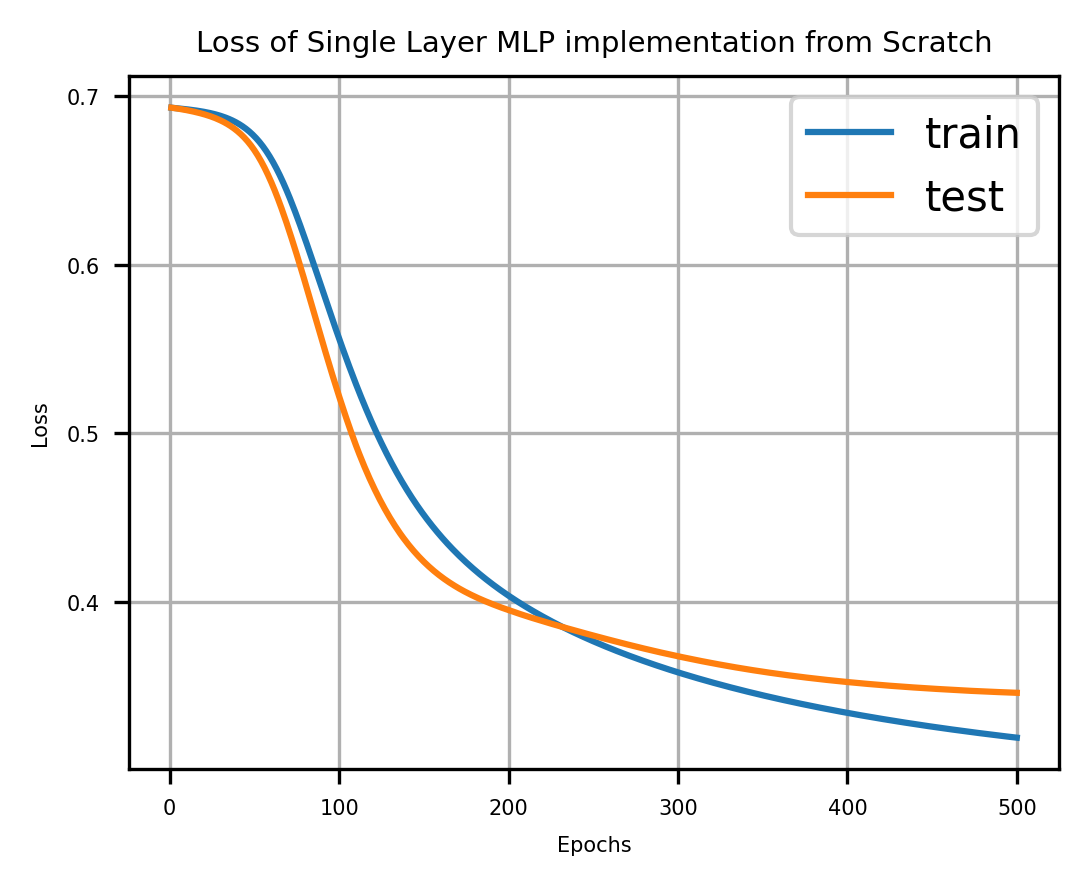

In [ ]:
import matplotlib.pyplot as plt

#figure parameters
size = 5
Y1 = losses
Y2 = test_losses
X = [i+1 for i in range(len(Y1))]

#plot the scatter plot
fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
ax.plot(X, Y1, label="train")
ax.plot(X, Y2, label="test")
ax.set_ylabel(r"Loss", fontsize=size)
ax.set_xlabel(r"Epochs", fontsize=size)
plt.title('Loss of Single Layer MLP implementation from Scratch', fontsize=size+2)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
ax.grid()
ax.legend()

fig.savefig("LossScratch.png")

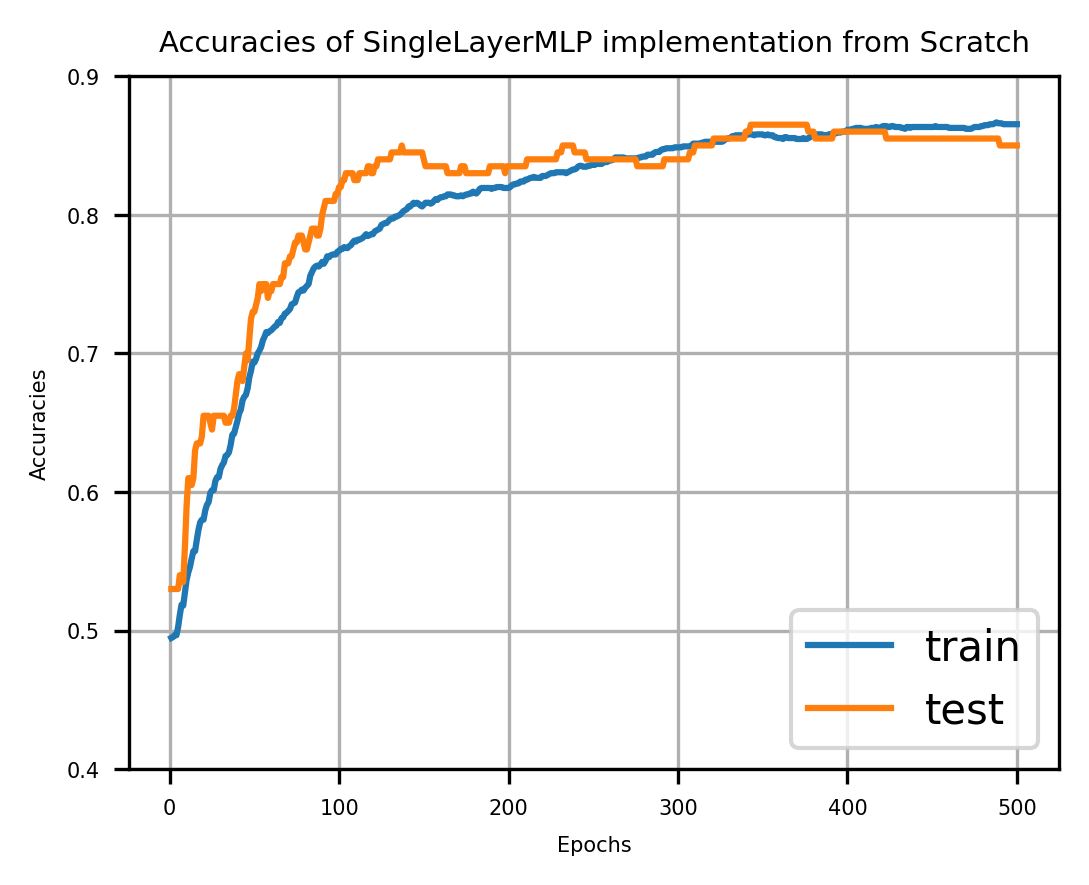

In [ ]:
#figure parameters
size = 5
Y1 = train_accuracies
Y2 = test_accuracies
X = [i+1 for i in range(len(Y1))]

#plot the scatter plot
fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
ax.plot(X, Y1, label="train")
ax.plot(X, Y2, label="test")
ax.set_ylabel(r"Accuracies", fontsize=size)
ax.set_xlabel(r"Epochs", fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.title('Accuracies of SingleLayerMLP implementation from Scratch', fontsize=size+2)
ax.set_ylim(0.4,0.9)
ax.grid()
ax.legend()

fig.savefig("AccuracyScratch.png")

# Implementing Single Layer Neural Network using Pytorch

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from typing import Optional, List, Tuple, Dict
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
class SingleLayerMLP(nn.Module):
    """Constructing a single layer neural network with PyTorch"""
    def __init__(self, indim, outdim, hidden_layer=100):
        super(SingleLayerMLP, self).__init__()
        self.linear1 = nn.Linear(indim, hidden_layer)  # Hidden Layer
        self.relu = nn.ReLU()  # ReLU activation in Pytorch
        self.linear2 = nn.Linear(hidden_layer, outdim) #Output Layer

    def forward(self, x):
        """
        x shape (batch_size, indim)
        """
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [ ]:
class DS(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray):
        self.length = len(X)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.long)

    def __getitem__(self, idx):
        x = self.X[idx, :]
        y = self.Y[idx]
        return (x, y)

    def __len__(self):
        return self.length

In [ ]:
def validate(loader, model, criterion):
    """Takes in a dataloader, then returns the model loss and accuracy on this loader"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    accuracy = 100 * correct / total
    return total_loss / len(loader), accuracy

In [ ]:
if __name__ == "__main__":
    indim = 60
    outdim = 2
    hidden_dim = 100
    lr = 0.01
    batch_size = 64
    epochs = 500

    # Dataset
    train_X_p = pd.read_csv("X_train.csv")
    train_y_p = pd.read_csv("y_train.csv")
    scaler = MinMaxScaler()
    train_X_p = pd.DataFrame(scaler.fit_transform(train_X_p), columns=train_X_p.columns).to_numpy()
    train_y_p = np.squeeze(train_y_p)
    m1, n1 = train_X_p.shape
    print(m1, n2)

    train_ds = DS(train_X_p, train_y_p)
    train_loader =DataLoader(train_ds, batch_size=batch_size)

    test_X_p = pd.read_csv("X_test.csv")
    test_y_p = pd.read_csv("y_test.csv").to_numpy()
    test_X_p = pd.DataFrame(scaler.fit_transform(test_X_p), columns=test_X_p.columns.to_numpy()).to_numpy()
    test_y_p = np.squeeze(test_y)
    m2, n2 = test_X_p.shape
    print(m1, n2)

    test_ds =DS(test_X_p, test_y_p)
    test_loader =DataLoader(test_ds, batch_size=batch_size)

    # Construct the Pytorchmodel
    Pytorchmodel = SingleLayerMLP(indim, outdim, hidden_dim).to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()

    #Using SGD optimizer
    optimizer = optim.SGD(Pytorchmodel.parameters(), lr=lr)

    # Training loop
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    for epoch in range(epochs):
        Pytorchmodel.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = Pytorchmodel(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted_classes = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(predicted_classes == labels).item()
            total_samples += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Calculate train accuracy
        train_accuracy = correct_predictions / total_samples
        train_accuracies.append(train_accuracy)

        # Calculate test loss and accuracy set
        test_loss, test_accuracy = validate(test_loader, Pytorchmodel, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy/100)

1500 60
1500 60


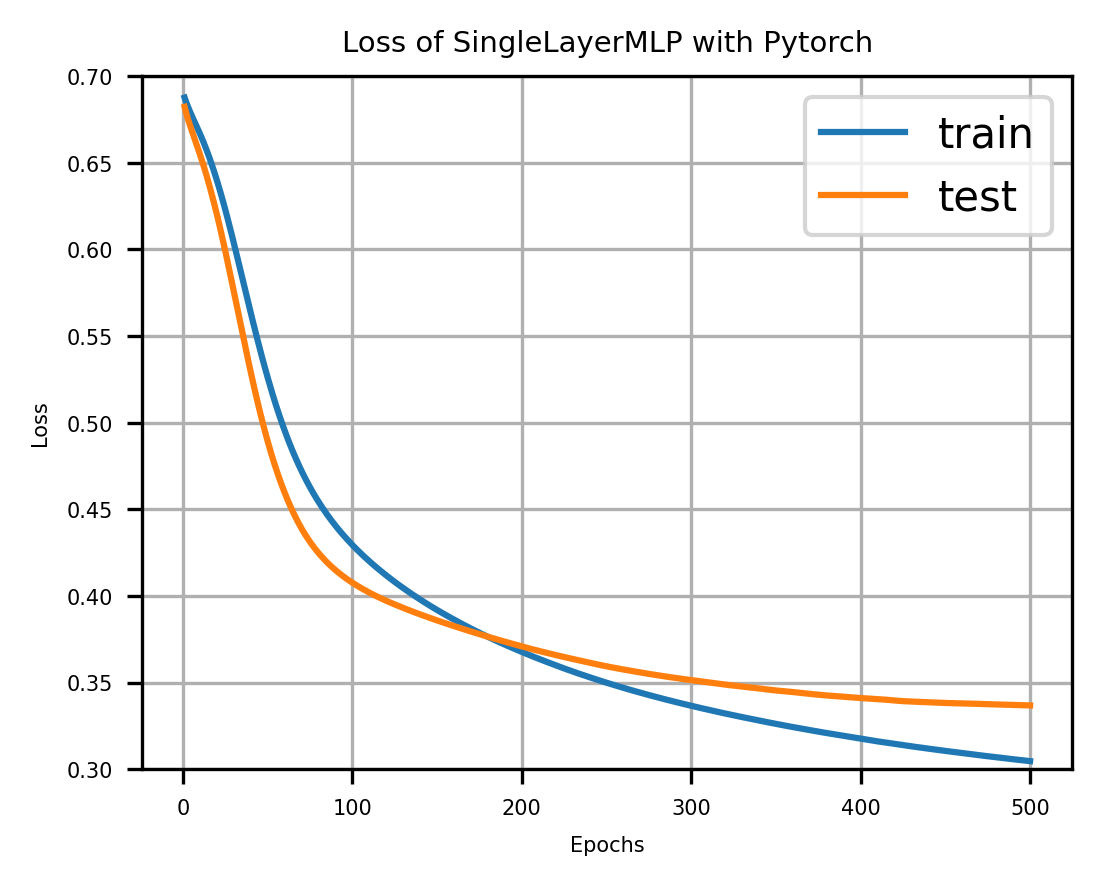

In [ ]:
#figure parameters
size = 5
Y1 = train_losses
Y2 = test_losses
X = [i+1 for i in range(len(Y1))]

#plot the scatter plot
fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
ax.plot(X, Y1, label="train")
ax.plot(X, Y2, label="test")
ax.set_ylabel(r"Loss", fontsize=size)
ax.set_xlabel(r"Epochs", fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.title('Loss of SingleLayerMLP with Pytorch', fontsize=size+2)
ax.set_ylim(0.3,0.7)
ax.grid()
ax.legend()

fig.savefig("LossPytorch.png")

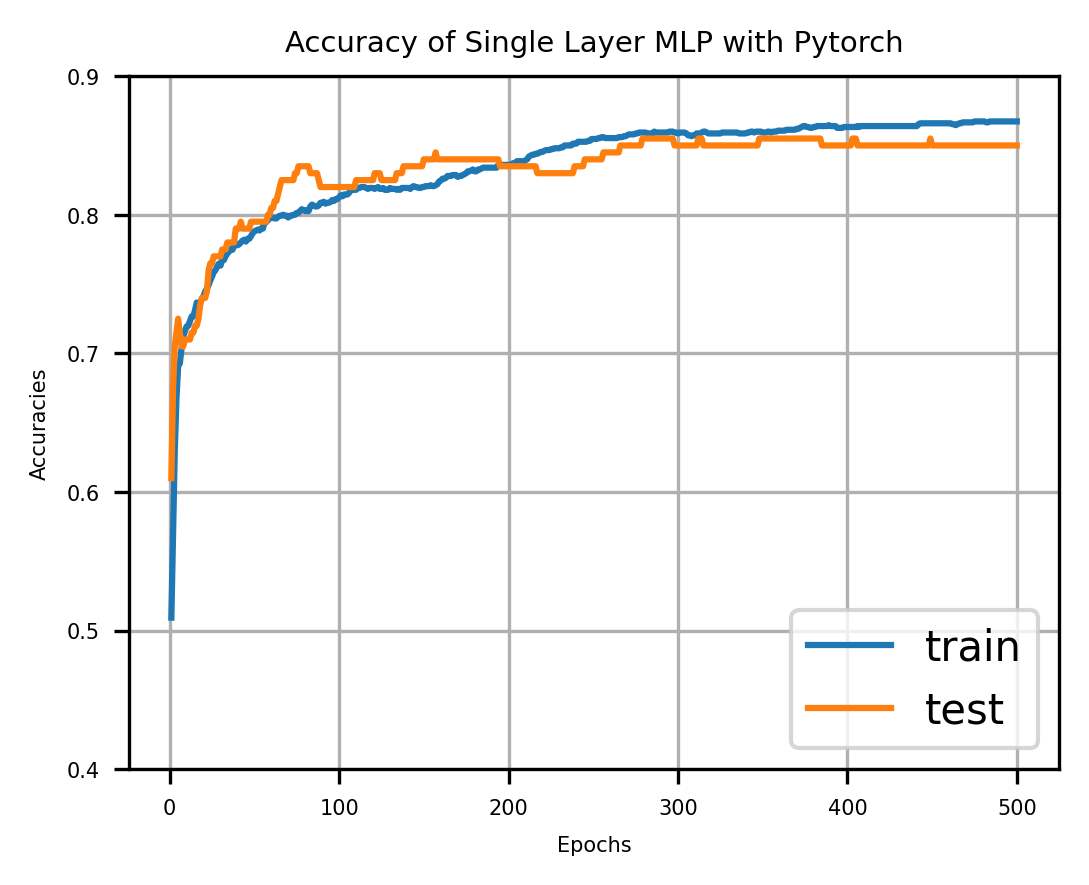

In [ ]:
#figure parameters
size = 5
Y1 = train_accuracies
Y2 = test_accuracies
X = [i+1 for i in range(len(Y1))]

#plot the scatter plot
fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
ax.plot(X, Y1, label="train")
ax.plot(X, Y2, label="test")
ax.set_ylabel(r"Accuracies", fontsize=size)
ax.set_xlabel(r"Epochs", fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.title('Accuracy of Single Layer MLP with Pytorch', fontsize=size+2)
ax.set_ylim(0.4,0.9)
ax.grid()
ax.legend()

fig.savefig("AccuracyPytorch.png")